# Marco Lavorini - Assignment 3

### dataset
Vito,Saverio. (2016). Air Quality. UCI Machine Learning Repository. https://doi.org/10.24432/C59K5F.

In [180]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
air_quality = fetch_ucirepo(id=360) 
  
# data (as pandas dataframes) 
X = air_quality.data.features 
y = air_quality.data.targets 
  
# metadata 
print(air_quality.metadata) 
  
# variable information 
print(air_quality.variables) 


{'uci_id': 360, 'name': 'Air Quality', 'repository_url': 'https://archive.ics.uci.edu/dataset/360/air+quality', 'data_url': 'https://archive.ics.uci.edu/static/public/360/data.csv', 'abstract': 'Contains the responses of a gas multisensor device deployed on the field in an Italian city. Hourly responses averages are recorded along with gas concentrations references from a certified analyzer. ', 'area': 'Computer Science', 'tasks': ['Regression'], 'characteristics': ['Multivariate', 'Time-Series'], 'num_instances': 9358, 'num_features': 15, 'feature_types': ['Real'], 'demographics': [], 'target_col': None, 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2008, 'last_updated': 'Sun Mar 10 2024', 'dataset_doi': '10.24432/C59K5F', 'creators': ['Saverio Vito'], 'intro_paper': {'title': 'On field calibration of an electronic nose for benzene estimation in an urban pollution monitoring scenario', 'authors': 'S. D. Vito, E. Massera, M. P

In [181]:
len(X)

9357

In [182]:
X.head()

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,3/10/2004,18:00:00,2.6,1360,150,11.9,1046,166,1056,113,1692,1268,13.6,48.9,0.7578
1,3/10/2004,19:00:00,2.0,1292,112,9.4,955,103,1174,92,1559,972,13.3,47.7,0.7255
2,3/10/2004,20:00:00,2.2,1402,88,9.0,939,131,1140,114,1555,1074,11.9,54.0,0.7502
3,3/10/2004,21:00:00,2.2,1376,80,9.2,948,172,1092,122,1584,1203,11.0,60.0,0.7867
4,3/10/2004,22:00:00,1.6,1272,51,6.5,836,131,1205,116,1490,1110,11.2,59.6,0.7888


In [183]:
# drop columns except for the target column 
df = X.drop(['Date','Time','CO(GT)', 'NMHC(GT)', 'NOx(GT)', 'NO2(GT)', 'T', 'RH', 'AH'], axis=1)

In [184]:
# move 'C6H6(GT)' to the last column
df = df[['PT08.S1(CO)', 'PT08.S2(NMHC)', 'PT08.S3(NOx)', 'PT08.S4(NO2)', 'PT08.S5(O3)', 'C6H6(GT)']]


In [185]:
len(df)

9357

In [186]:
# drop all the rows with 'C6H6(GT)' as -200
df = df[df['C6H6(GT)'] != -200]
len(df)

8991

In [187]:
# do the same for all the other columns
df = df[df['PT08.S1(CO)'] != -200]
df = df[df['PT08.S2(NMHC)'] != -200]
df = df[df['PT08.S3(NOx)'] != -200]
df = df[df['PT08.S4(NO2)'] != -200]
df = df[df['PT08.S5(O3)'] != -200]
len(df)

8991

In [188]:
#print the PT08.S1(CO) column
df['PT08.S1(CO)']
#print the min value
df['PT08.S1(CO)'].min()

647

In [189]:
# print the C6H6 column

print(X['C6H6(GT)'][:5])


0    11.9
1     9.4
2     9.0
3     9.2
4     6.5
Name: C6H6(GT), dtype: float64


In [190]:
# count the null values in the C6H6 column
# count how many values are -200
print((df['C6H6(GT)'] == -200).sum())

0


In [191]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [192]:
df.head()

,PT08.S1(CO),PT08.S2(NMHC),PT08.S3(NOx),PT08.S4(NO2),PT08.S5(O3),C6H6(GT)
0,1360,1046,1056,1692,1268,11.9
1,1292,955,1174,1559,972,9.4
2,1402,939,1140,1555,1074,9.0
3,1376,948,1092,1584,1203,9.2
4,1272,836,1205,1490,1110,6.5


In [193]:
# drop None values
df = df.dropna()
len(df)

8991

In [194]:
# split into train and test sets
dataset = df.values

train_size = int(len(dataset) * 0.8)
test_size = len(dataset) - train_size
validation_size = int(train_size * 0.2)
train_size = train_size - validation_size

print(train_size, validation_size, test_size)
print(len(dataset))
print(train_size + validation_size + test_size)

5754 1438 1799
8991
8991


In [195]:
# normalize the dataset
X_ = dataset[:, :-1]
y_ = dataset[:, -1]
train_X, train_y = X_[:train_size], y_[:train_size]
validation_X, validation_y = X_[train_size:train_size+validation_size], y_[train_size:train_size+validation_size]
test_X, test_y = X_[train_size+validation_size:], y_[train_size+validation_size:]

scaler = MinMaxScaler(feature_range=(0, 1))
train_X = scaler.fit_transform(train_X)
validation_X = scaler.transform(validation_X)
test_X = scaler.transform(test_X)

scaler_y = MinMaxScaler(feature_range=(0, 1))
train_y = scaler_y.fit_transform(train_y.reshape(-1, 1))
validation_y = scaler_y.transform(validation_y.reshape(-1, 1))
test_y = scaler_y.transform(test_y.reshape(-1, 1))

# reshape outputs, maybe need to reshape X to have the step embeddend in the shape, it would be (n x 1 x m) instead of n x m

In [196]:
print(train_X.shape, train_y.shape, validation_X.shape, validation_y.shape, test_X.shape, test_y.shape)
"""train_y = train_y.reshape(-1,1)
test_y = test_y.reshape(-1,1)
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)"""

(5754, 5) (5754, 1) (1438, 5) (1438, 1) (1799, 5) (1799, 1)


'train_y = train_y.reshape(-1,1)\ntest_y = test_y.reshape(-1,1)\nprint(train_X.shape, train_y.shape, test_X.shape, test_y.shape)'

In [197]:
model =  Sequential()

model.add(LSTM(4, input_shape=(train_X.shape[1], 1)))
model.add(Dropout(0.2))
model.add(Dense(1))


/Users/lavo/Desktop/Projects/ISPR-Midterms/.venv/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [198]:
model.compile(loss='mean_squared_error', optimizer='adam')

In [199]:
print(model.summary())

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_5 (LSTM)                   │ (None, 4)              │            96 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 4)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 101 (404.00 B)

 Trainable params: 101 (404.00 B)

 Non-trainable params: 0 (0.00 B)

None


In [200]:
history = model.fit(train_X, train_y, validation_data=[validation_X, validation_y], epochs=20, batch_size=50, verbose=1, shuffle=False)

Epoch 1/20


116/116 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.1526 - val_loss: 0.0410
Epoch 2/20
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0297 - val_loss: 0.0314
Epoch 3/20
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0269 - val_loss: 0.0285
Epoch 4/20
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0234 - val_loss: 0.0258
Epoch 5/20
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0229 - val_loss: 0.0233
Epoch 6/20
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0192 - val_loss: 0.0207
Epoch 7/20
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0183 - val_loss: 0.0183
Epoch 8/20
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0168 - val_loss: 0.0159
Epoch 9/20
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0144 - val_loss: 0.0134
Epoch 10/20
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0124 - val_loss: 0.0109
Epoch 11/20
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0119 - val_loss: 0.0086
Epoch 12/20
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.

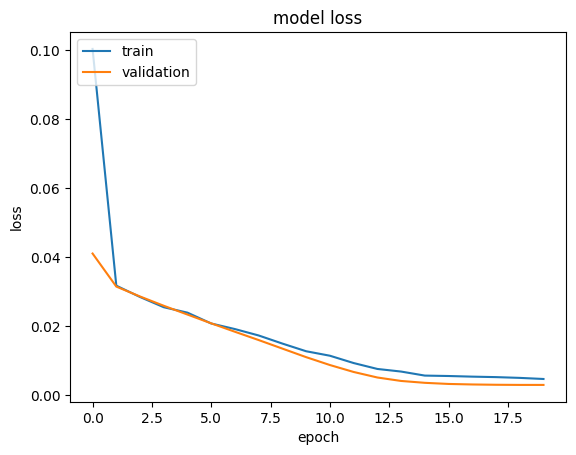

In [201]:
# print the loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()


In [202]:
predict = model.predict(test_X)
predict.shape

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


(1799, 1)

In [203]:
test_X

array([[0.27609178, 0.298125  , 0.26175743, 0.08882979, 0.40292553],
       [0.25092524, 0.25375   , 0.29022277, 0.06595745, 0.36037234],
       [0.23242043, 0.25      , 0.30569307, 0.06702128, 0.32890071],
       ...,
       [0.33530718, 0.41      , 0.1720297 , 0.18404255, 0.36746454],
       [0.23242043, 0.34625   , 0.23329208, 0.07765957, 0.22473404],
       [0.28275352, 0.4       , 0.20358911, 0.12446809, 0.24512411]])

In [204]:
predict = scaler_y.inverse_transform(predict)

In [205]:
# calculate root mean squared error
test_y = scaler_y.inverse_transform(test_y)
rmse = math.sqrt(mean_squared_error(test_y, predict))
print('Test RMSE: %.3f' % rmse)


Test RMSE: 1.884


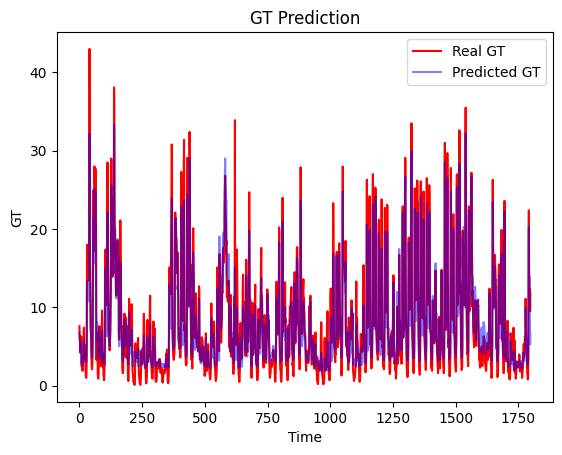

In [206]:
# plot the data
plt.plot(test_y, color = 'red', label = 'Real GT')
plt.plot(predict, color = 'blue', label = 'Predicted GT', alpha=0.5)
plt.title('GT Prediction')

plt.xlabel('Time')
plt.ylabel('GT')
plt.legend()
plt.show()

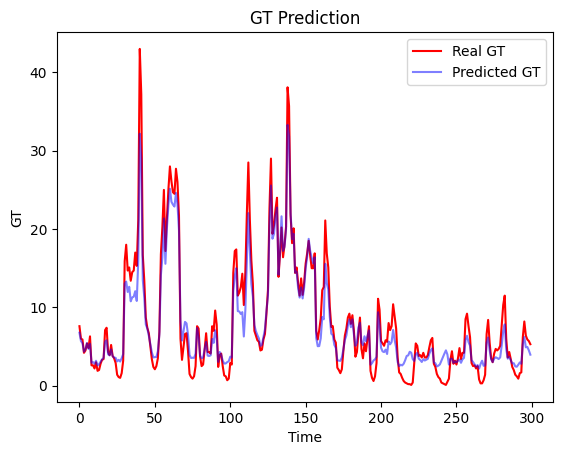

In [226]:
# plot the prediction more readable
plt.plot(test_y[0:300], color = 'red', label = 'Real GT')
plt.plot(predict[0:300], color = 'blue', label = 'Predicted GT', alpha=0.5)
plt.title('GT Prediction')

plt.xlabel('Time')
plt.ylabel('GT')
plt.legend()
plt.show()

---

# second model

create the dataset with x 

In [208]:
X_2, y_2 = [], []
for i in range(len(y_)-1):
    X_2.append(y_[i])
    y_2.append(y_[i+1])
X_2 = np.array(X_2)
y_2 = np.array(y_2)

In [209]:
print(X_2.shape, y_2.shape)

(8990,) (8990,)


In [210]:
# split into train and test sets
dataset = df.values

train_size = int(len(X_2) * 0.8)
test_size = len(X_2) - train_size
validation_size = int(train_size * 0.2)
train_size = train_size - validation_size

print(train_size, validation_size, test_size)
print(len(X_2))
print(train_size + validation_size + test_size)

5754 1438 1798
8990
8990


In [211]:
x_train, y_train = X_2[:train_size], y_2[:train_size]
x_validation, y_validation = X_2[train_size:train_size+validation_size], y_2[train_size:train_size+validation_size]
x_test, y_test = X_2[train_size+validation_size:], y_2[train_size+validation_size:]

In [212]:
x_train = scaler.fit_transform(x_train.reshape(-1, 1))
x_validation = scaler.transform(x_validation.reshape(-1, 1))
x_test = scaler.transform(x_test.reshape(-1, 1))

y_train = scaler.transform(y_train.reshape(-1, 1))
y_validation = scaler.transform(y_validation.reshape(-1, 1))
y_test = scaler.transform(y_test.reshape(-1, 1))


In [213]:
print(x_train.shape, y_train.shape, x_validation.shape, y_validation.shape, x_test.shape, y_test.shape)

(5754, 1) (5754, 1) (1438, 1) (1438, 1) (1798, 1) (1798, 1)


# model 2, the same for different data

In [214]:
model2 =  Sequential()

model2.add(LSTM(4, input_shape=(1, 1)))
model2.add(Dropout(0.2))
model2.add(Dense(1))

/Users/lavo/Desktop/Projects/ISPR-Midterms/.venv/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [215]:
model2.compile(loss='mean_squared_error', optimizer='adam')

In [216]:
print(model2.summary())

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 4)              │            96 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 4)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 101 (404.00 B)

 Trainable params: 101 (404.00 B)

 Non-trainable params: 0 (0.00 B)

None


In [217]:
history = model2.fit(x_train, y_train, validation_data=[x_validation, y_validation], epochs=20, batch_size=50, verbose=1, shuffle=False)

Epoch 1/20


116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0338 - val_loss: 0.0174
Epoch 2/20
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 839us/step - loss: 0.0140 - val_loss: 0.0148
Epoch 3/20
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 836us/step - loss: 0.0131 - val_loss: 0.0129
Epoch 4/20
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 823us/step - loss: 0.0117 - val_loss: 0.0111
Epoch 5/20
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 822us/step - loss: 0.0105 - val_loss: 0.0096
Epoch 6/20
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 814us/step - loss: 0.0096 - val_loss: 0.0083
Epoch 7/20
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 810us/step - loss: 0.0090 - val_loss: 0.0075
Epoch 8/20
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 814us/step - loss: 0.0086 - val_loss: 0.0069
Epoch 9/20
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 810us/step - loss: 0.0082 - val_loss: 0.0066
Epoch 10/20
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 813us/step - loss: 0.0081 - val_loss: 0.0065
Epoch 11/20
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 815us/step - loss: 0.0082 - val_loss: 0.0065
Epoch 12/20
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s

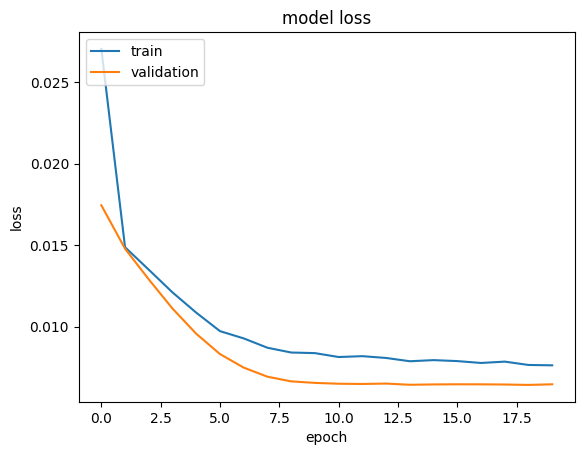

In [218]:
# print the loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()


In [219]:
predict2 = model2.predict(x_test)
predict2.shape

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


(1798, 1)

In [220]:
predict2 = scaler.inverse_transform(predict2)

In [221]:
# calculate root mean squared error
y_test = scaler.inverse_transform(y_test)
rmse2 = math.sqrt(mean_squared_error(y_test, predict2))
print('Test RMSE: %.3f' % rmse2)


Test RMSE: 3.938


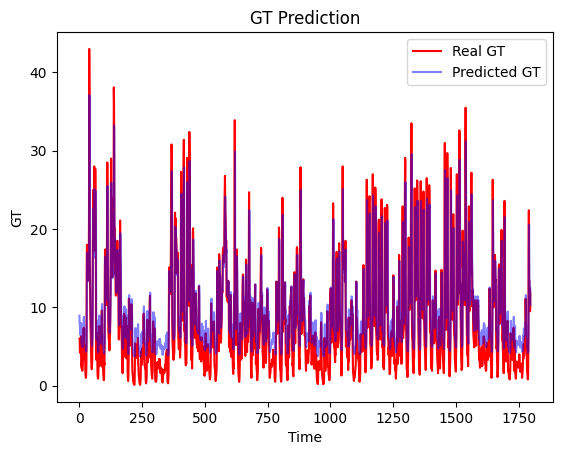

In [222]:
# plot the data
plt.plot(y_test, color = 'red', label = 'Real GT')
plt.plot(predict2, color = 'blue', label = 'Predicted GT', alpha=0.5)
plt.title('GT Prediction')

plt.xlabel('Time')
plt.ylabel('GT')
plt.legend()
plt.show()

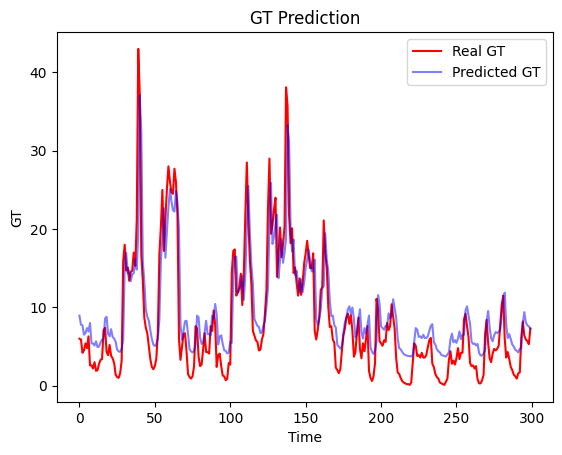

In [227]:
# plot the data
plt.plot(y_test[:300], color = 'red', label = 'Real GT')
plt.plot(predict2[:300], color = 'blue', label = 'Predicted GT', alpha=0.5)
plt.title('GT Prediction')

plt.xlabel('Time')
plt.ylabel('GT')
plt.legend()
plt.show()

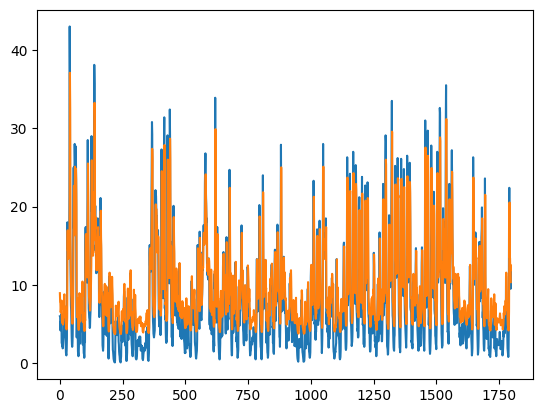

In [224]:
# fill the distance of the 2 function with seaborn
import seaborn as sns
sns.lineplot(x=range(len(y_test)), y=y_test.reshape(-1))
sns.lineplot(x=range(len(predict2)), y=predict2.reshape(-1))


plt.show()



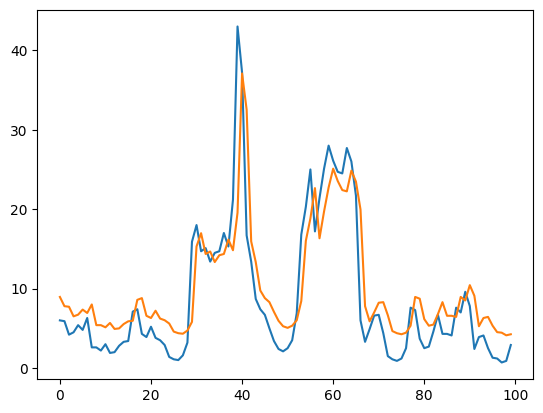

In [225]:
# zoom first 100 values
sns.lineplot(x=range(100), y=y_test[:100].reshape(-1))
sns.lineplot(x=range(100), y=predict2[:100].reshape(-1))
plt.show()
